# Car Price Prediction

## Import Libraries

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.svm import SVR
from sklearn import metrics

## Read Dataset

In [249]:
df = pd.read_csv('car_data.csv')

## Dataset Overview

In [250]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [251]:
df.shape

(301, 9)

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [253]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [254]:
df.describe(include='object')

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


## Data Preparation

## Drop and transform some features

Since the *Car_Name* column has too many unique values, it is better to remove it.

In [255]:
df.drop('Car_Name', axis=1, inplace=True)

In [256]:
df.insert(0, "Age", df["Year"].max()+1-df["Year"] )
df.drop('Year', axis=1, inplace=True)
df.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Outlier Detection

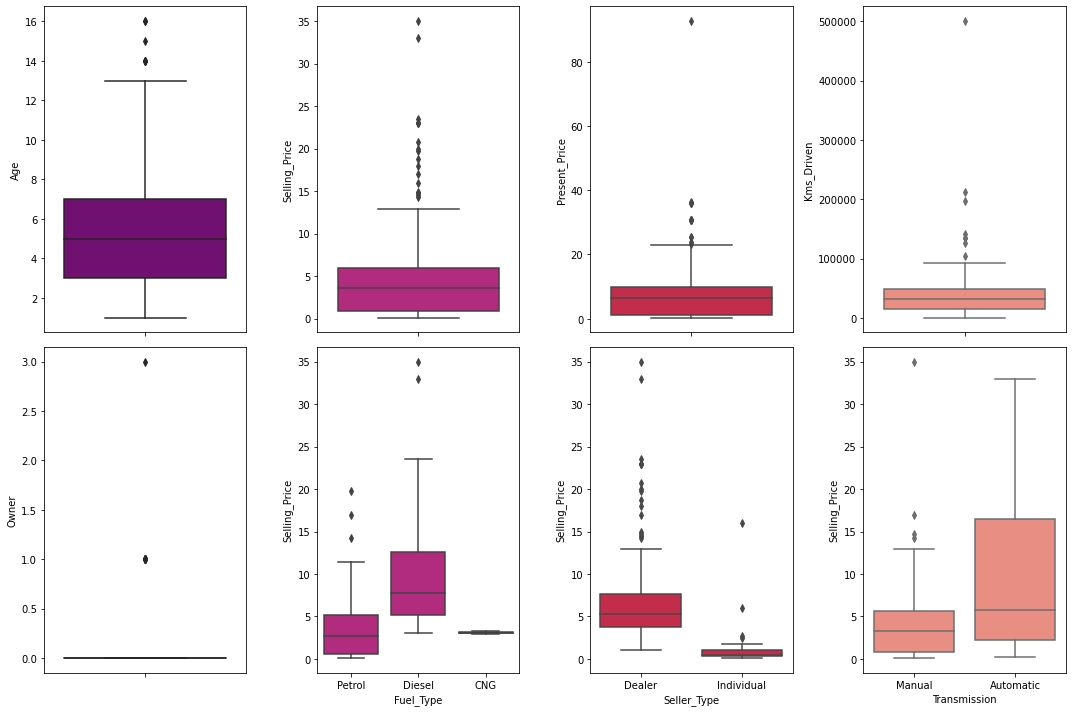

In [257]:
f, ax = plt.subplots(2, 4, figsize=(15,10), tight_layout = True)

columns = ['Age', 'Selling_Price', 'Present_Price', 'Kms_Driven',
        'Owner', 'Fuel_Type', 'Seller_Type', 'Transmission']
colors = ['purple', 'mediumvioletred', 'crimson', 'salmon', 'peachpuff']
for i, col in enumerate(columns):
    y = i // 4
    x = i % 4
    if i < 5:
        sns.boxplot(y=col, data=df, ax=ax[y,x], color=colors[x])
    else:
        sns.boxplot(x=col, y='Selling_Price', data=df, ax=ax[y,x], color=colors[x])

**As can be seen from the boxplots, there are outliers in the dataset.**

In [258]:
df = df[(df['Selling_Price'] < 31) & (df['Kms_Driven'] < 300000)]
df.reset_index(drop=True, inplace=True)

### Discover Missing Values

Text(0.5, 1.0, 'Missing values in dataset')

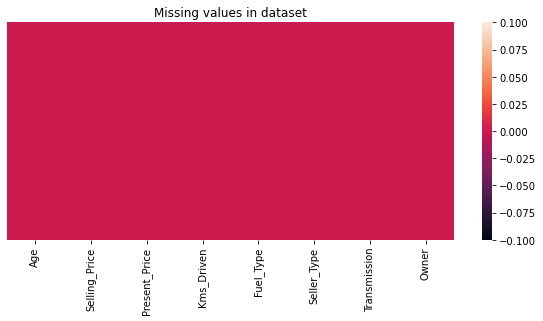

In [259]:
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), yticklabels=False)
plt.title('Missing values in dataset')

**There is no missing values in the dataset.**

## EDA

### Categorical Variables Analysis

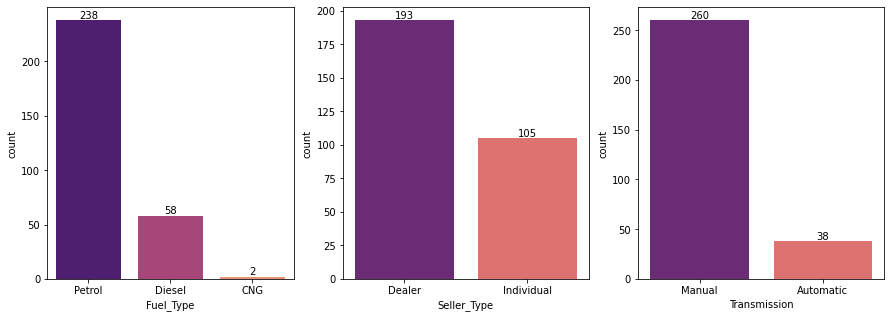

In [260]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, col in enumerate(columns[5:]):
    graph = sns.countplot(x=col, data=df, ax=ax[i], palette='magma')
    for cont in graph.containers:
        graph.bar_label(cont)

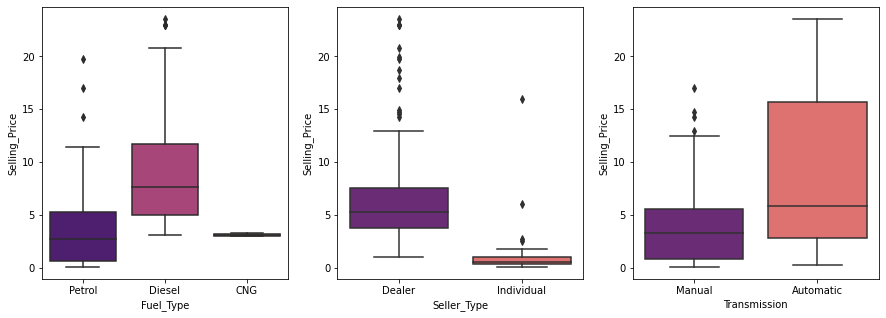

In [261]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, col in enumerate(columns[5:]):
    sns.boxplot(x=col, y='Selling_Price', data=df, ax=ax[i], palette='magma')

### Numerical Variables Analysis

(0.0, 1.0, 0.0, 1.0)

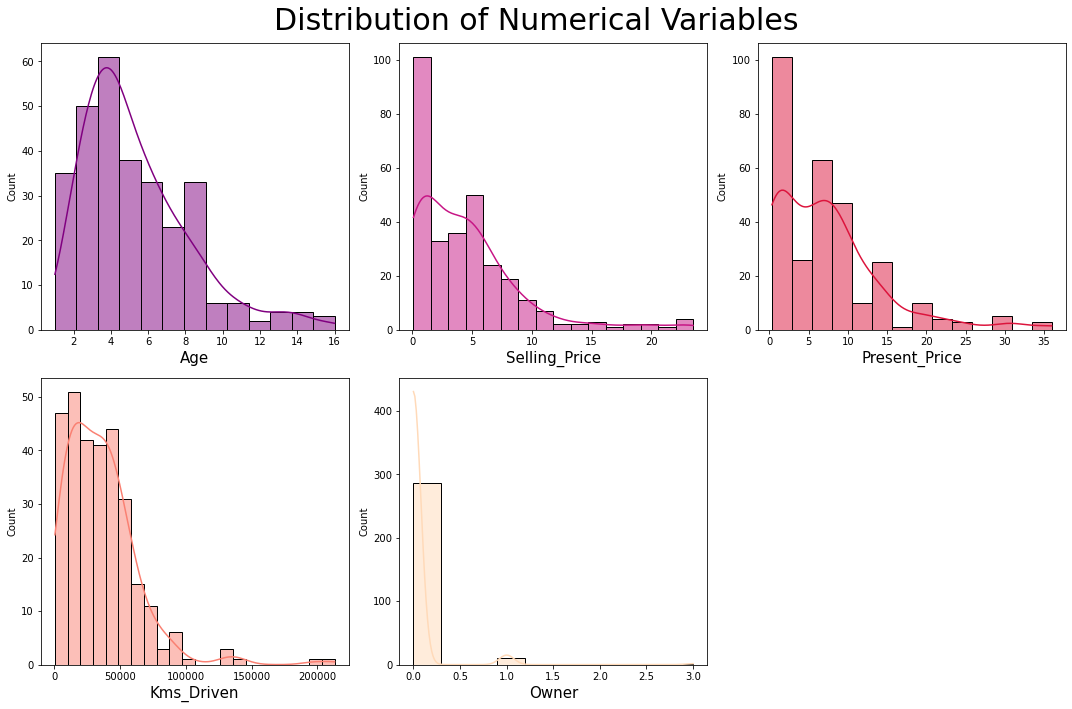

In [262]:
f, ax = plt.subplots(2, 3, figsize=(15, 10), tight_layout = True)


for i, col in enumerate(columns[:-3]):
    y = i // 3
    x = i % 3
    sns.histplot(df[col], kde=True, ax=ax[y,x], color=colors[i])
    ax[y,x].set_xlabel(col, fontsize=15)

plt.suptitle('Distribution of Numerical Variables', fontsize=30)
ax[1, 2].axis('off')

**All variables have a non-normal distribution.**

## Categorical Variables Encoding

In [263]:
df = pd.get_dummies(df, columns=columns[5:], drop_first=True)
df.head(5)

,Age,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5,3.35,5.59,27000,0,0,1,0,1
1,6,4.75,9.54,43000,0,1,0,0,1
2,2,7.25,9.85,6900,0,0,1,0,1
3,8,2.85,4.15,5200,0,0,1,0,1
4,5,4.60,6.87,42450,0,1,0,0,1


## Correlation Analysis

<AxesSubplot:>

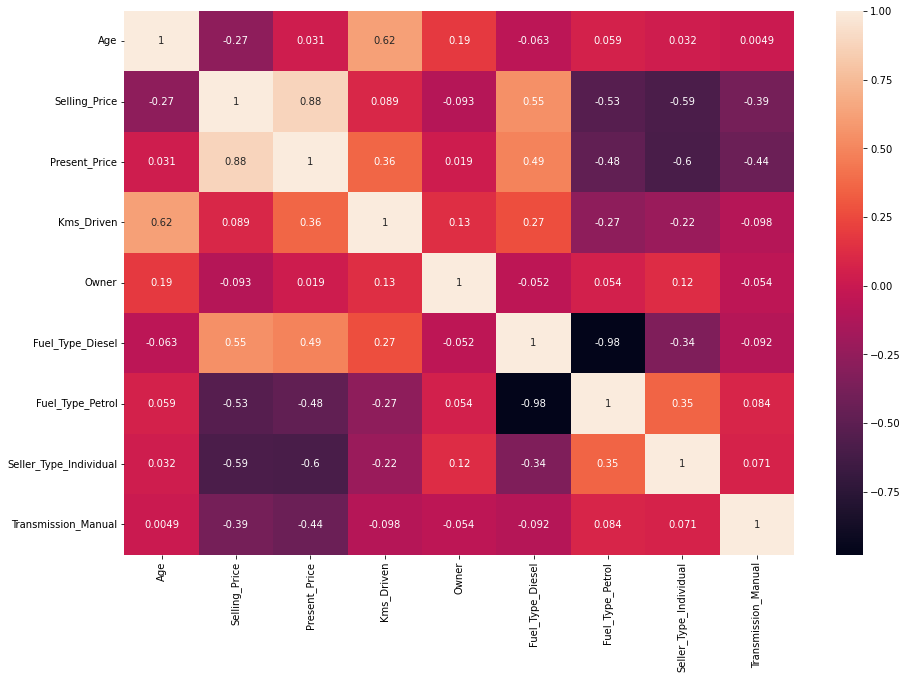

In [264]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True)

**The target variable *Selling_Price* is highly correlated with *Present_Price*.
There are also some independent variables that are highly correlated: *Fuel_Type_diesel* - *Fuel_Type_Petrol* (*-0.98*), *Kms_Driven* - *Years* (*-0.62*).

## Linear Regression

### Split Dataset

In [265]:
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Scale Data

In [266]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train the Model

In [267]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [268]:
pd.DataFrame(data = np.append(lin_reg.intercept_, lin_reg.coef_),
             index=['intercept'] + [i+' coef.' for i in X.columns],
             columns=['Value']).sort_values('Value', ascending=False)

,Value
intercept,4.340337
Present_Price coef.,3.525922
Fuel_Type_Diesel coef.,0.839550
Fuel_Type_Petrol coef.,0.213962
Transmission_Manual coef.,-0.217786
Owner coef.,-0.271797
Seller_Type_Individual coef.,-0.441275
Kms_Driven coef.,-0.641123
Age coef.,-0.781535


### Model Evaluation

In [269]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MSE, RMSE, R2_score], 
                        index=['MSE', 'RMSE', 'R2-score'],
                        columns=[model_name])

In [270]:
model_evaluation(lin_reg, X_test_scaled, y_test, 'Linear Reg.')

,Linear Reg.
MSE,2.330806
RMSE,1.526698
R2-score,0.892802


### Cross-Validation

In [271]:
pipeline = make_pipeline(StandardScaler(),  LinearRegression())
    
kf = KFold(n_splits=6, shuffle=True, random_state=0)
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MSE_mean = -result['test_neg_mean_squared_error'].mean()
MSE_std = -result['test_neg_mean_squared_error'].std()
RMSE_mean = -result['test_neg_root_mean_squared_error'].mean()
RMSE_std = -result['test_neg_root_mean_squared_error'].std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()
    
pd.DataFrame({'Mean': [MSE_mean, RMSE_mean, R2_Score_mean],
                     'Std': [MSE_std, RMSE_std, R2_Score_std]},
                    index=['MSE', 'RMSE', 'R2-score'])

,Mean,Std
MSE,2.640816,-0.727622
RMSE,1.608674,-0.230184
R2-score,0.834602,0.084963


### Assumptions

**1. Linearity**

In [272]:
def residuals(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    results = pd.DataFrame({'Actual': y_test, 
                           'Predicted': y_pred})
    results['Residuals'] = abs(results['Actual']) - abs(results['Predicted'])
    
    return results


def linear_assumption(model, X_test, y_test):
    
    results = residuals(model, X_test, y_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    sns.regplot(x='Predicted', y='Actual', data=results, ax=ax[0], lowess=True)
    ax[0].set_title('Actual vs. Predicted Values', fontsize=15)
    
    sns.regplot(x='Predicted', y='Residuals', data=results, ax=ax[1], lowess=True)
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=15)

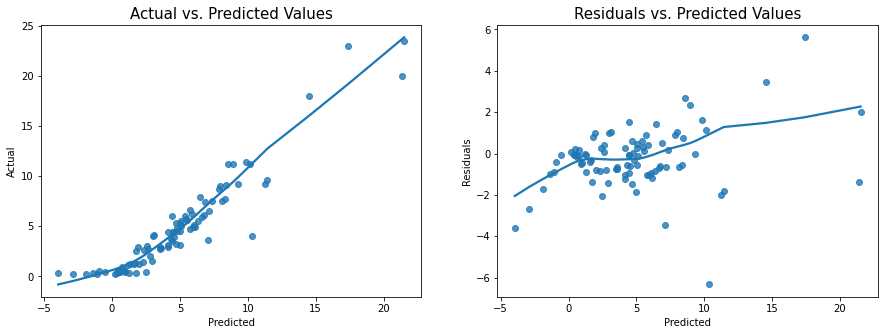

In [273]:
linear_assumption(lin_reg, X_test_scaled, y_test)

As we can see from the plots, the linear assumption is not satisfied.

To solve this problem, we can apply a nonlinear transformation or add polynomial terms to some of the predictors.

**2. Normality of Residuals**

In [274]:
def normal_errors_assumption(model, X_test, y_test):
    
    results = residuals(model, X_test, y_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    sns.histplot(x='Residuals', data=results, kde=True, bins=30, ax=ax[0])
    ax[0].set_title('Distribution of Residuals', fontsize=15)
    
    stats.probplot(results['Residuals'], dist='norm', plot=ax[1])
    ax[1].set_title('Residuals Q-Q Plot', fontsize=15)    

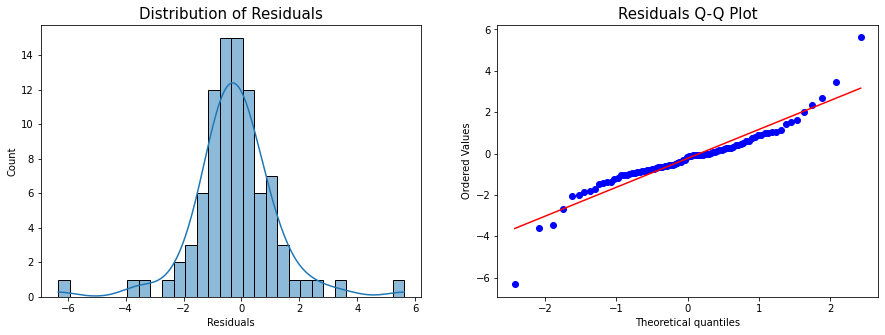

In [275]:
normal_errors_assumption(lin_reg, X_test_scaled, y_test)

Residuals are not normally distributed. Assumption not satisfied.

This can be solved by applying a nonlinear transformation of target variable and features and by removing potential outliers.

**3. Independence**

In [276]:
def multicollinearity_assumption(X):
    
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    multicollinearity_10 = sum([1 for i in vif if i>10])
    
    multicollinearity_100 =sum([1 for i in vif if i>100])
    
    if multicollinearity_100 == 0:
        if multicollinearity_10 == 0:
            print("There is no multicollinearity.")
        else:
            print("There is possible multicollinearity.")
    else:
        print("There is multicollinearity.")
        
    return pd.DataFrame({'vif': vif}, index=X.columns).round(2)

In [277]:
multicollinearity_assumption(X)

There is possible multicollinearity.


,vif
Age,8.16
Present_Price,5.21
Kms_Driven,5.44
Owner,1.10
Fuel_Type_Diesel,6.02
Fuel_Type_Petrol,16.91
Seller_Type_Individual,2.64
Transmission_Manual,9.59


There is possible multicollinearity in the dataset (VIF for *Fuel_Type_Petrol* equals 16.92), so the assumption isn't satisfied.

To solve this problem, we can use regularization, features with a high vif value can be removed, or we can use PCA (reducing features to a smaller set of uncorrelated components).

**4. No Autocorrelation of Residuals**

In [278]:
def autocorrelation_assumption(model, X_test, y_test):
    
    results = residuals(model, X_test, y_test)
    
    durbinWatson = durbin_watson(results['Residuals'])
    print('Durbin-Watson:', round(durbinWatson,3))
    
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation. Assumption not satisfied.', '\n')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation. Assumption not satisfied.', '\n')
    else:
        print('No autocorrelation. Assumption satisfied.', '\n')

In [279]:
autocorrelation_assumption(lin_reg, X_test_scaled, y_test)

Durbin-Watson: 1.608
No autocorrelation. Assumption satisfied. 



In the case of autocorrelation of residuals, it can be fixed by adding interaction terms.

**5. Homoscedasticity**

In [280]:
def homoscedasticity_assumption(model, X_test, y_test):
    
    results = residuals(model, X_test, y_test)
    
    fig = plt.figure(figsize=(5,5))
    
    sns.regplot(x='Predicted', y='Residuals', data=results, lowess=True,
               line_kws={'color':'#ff7000','ls':'--'})
    plt.title('Residuals vs. Predicted Values', fontsize=15)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)  

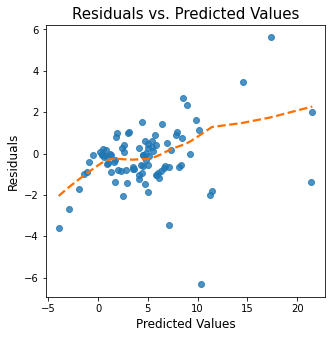

In [281]:
homoscedasticity_assumption(lin_reg, X_test_scaled, y_test)

The orange line isn't flat, so assumption is not satisfied.

In the case of heteroscedasticity, it can be solved by outlier removal, applying log transformation of independent variables, and applying polynomial regression.

**Conclusions:**
* In order to satisfy the linear assumption, it is necessary to apply box-cox transformation on the entire dataset.
* In order to improve the satisfaction of normality of residuals and homoscedasticity assumption, we can apply polynomial regression.
* We can drop *Fuel_Type_Petrol* to get rid of multicollinearity.
* In order to reduce the probability of the model to be overfit, we can use regularization.

In [282]:
df.drop('Fuel_Type_Petrol', axis=1, inplace=True)

## Box-Cox Transformation

**Transform Training Data**

In [283]:
fitted_lambda = pd.Series(np.zeros(len(df.columns), dtype=np.float64), index=df.columns)

y_train, fitted_lambda['Selling_Price'] = stats.boxcox(y_train+1)
for col in X_train.columns:
    X_train[col], fitted_lambda[col] = stats.boxcox(X_train[col]+1)
    
fitted_lambda

Age                       -0.340497
Selling_Price             -0.063089
Present_Price              0.053638
Kms_Driven                 0.355407
Owner                    -30.008057
Fuel_Type_Diesel          -7.690920
Seller_Type_Individual    -2.154108
Transmission_Manual       15.068304
Fuel_Type_Petrol           7.268752
dtype: float64

**Transform Test Data**

In [284]:
y_test = stats.boxcox(y_test+1, fitted_lambda['Selling_Price'])
for col in X_test.columns:
    X_test[col] = stats.boxcox(X_test[col]+1, fitted_lambda[col])

In [285]:
y_train = pd.DataFrame(y_train, index=X_train.index, columns=['Selling_Price'])
y_test = pd.DataFrame(y_test, index=X_test.index, columns=['Selling_Price'])

X_boxcox = pd.concat([X_train, X_test])
y_boxcox = pd.concat([y_train, y_test])

df_boxcox = pd.concat([X_boxcox, y_boxcox], axis=1)
df_boxcox.sort_index(inplace=True)

df_boxcox.drop('Fuel_Type_Petrol', axis=1, inplace=True)

Text(0.5, 0.98, 'Data Transformation using Box-Cox')

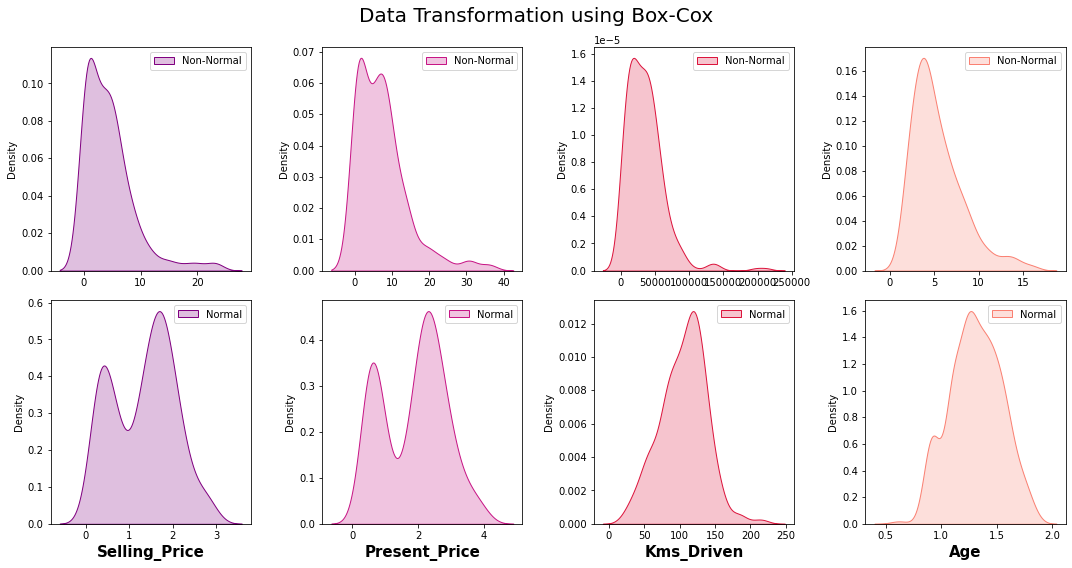

In [286]:
f, ax = plt.subplots(2, 4, figsize=(15, 8), tight_layout = True)

vars = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Age']

for i, var in enumerate(vars):
    sns.kdeplot(df[var], fill=True, label='Non-Normal', ax=ax[0,i], color=colors[i])
    ax[0,i].set_xlabel('', fontsize=15)
    
    sns.kdeplot(df_boxcox[var], fill=True, label='Normal', color=colors[i], ax=ax[1,i])
    ax[1,i].set_xlabel(var, fontsize=15, fontweight='bold')

    ax[0,i].legend(loc="upper right")
    ax[1,i].legend(loc="upper right")
    
plt.suptitle('Data Transformation using Box-Cox', fontsize=20)

In [287]:
X = df_boxcox.drop('Selling_Price', axis=1)
y = df_boxcox['Selling_Price']

## 2nd-order Polynomial Regression

###  Create the features

In [288]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
poly_features_names = poly_features.get_feature_names_out(X.columns)
X_poly = pd.DataFrame(X_poly, columns=poly_features_names)
X_poly.head(5)

,Age,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,Age^2,Age Present_Price,Age Kms_Driven,...,Owner^2,Owner Fuel_Type_Diesel,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel^2,Fuel_Type_Diesel Seller_Type_Individual,Fuel_Type_Diesel Transmission_Manual,Seller_Type_Individual^2,Seller_Type_Individual Transmission_Manual,Transmission_Manual^2
0,1.341267,1.984201,102.920990,0.0,0.000000,0.0,2279.99762,1.798997,2.661343,138.044512,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,5.198389e+06
1,1.422857,2.510407,121.937512,0.0,0.129394,0.0,2279.99762,2.024523,3.571950,173.499684,...,0.0,0.0,0.0,0.0,0.016743,0.0,295.018481,0.0,0.0,5.198389e+06
2,0.916525,2.543323,62.296699,0.0,0.000000,0.0,2279.99762,0.840019,2.331020,57.096503,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,5.198389e+06
3,1.547027,1.713200,56.070320,0.0,0.000000,0.0,2279.99762,2.393292,2.650366,86.742289,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,5.198389e+06
4,1.341267,2.181535,121.368065,0.0,0.129394,0.0,2279.99762,1.798997,2.926021,162.786961,...,0.0,0.0,0.0,0.0,0.016743,0.0,295.018481,0.0,0.0,5.198389e+06


### Split Dataset

In [289]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)

### Scale Data

In [290]:
scaler = StandardScaler()

X_poly_train = scaler.fit_transform(X_poly_train)
X_poly_train = pd.DataFrame(X_poly_train, columns=poly_features_names)

X_poly_test = scaler.transform(X_poly_test)
X_poly_test = pd.DataFrame(X_poly_test, columns=poly_features_names)

### Train the Model

In [291]:
poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_poly_train)

LinearRegression()

### Model Evaluation

In [292]:
model_evaluation(poly_reg, X_poly_test, y_poly_test, 'Polynomial Reg.')

,Polynomial Reg.
MSE,0.011049
RMSE,0.105114
R2-score,0.977992


### Assumptions

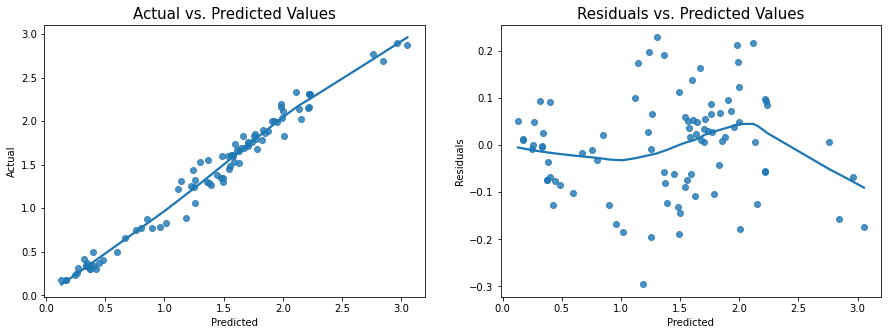

In [293]:
linear_assumption(poly_reg, X_poly_test, y_poly_test)

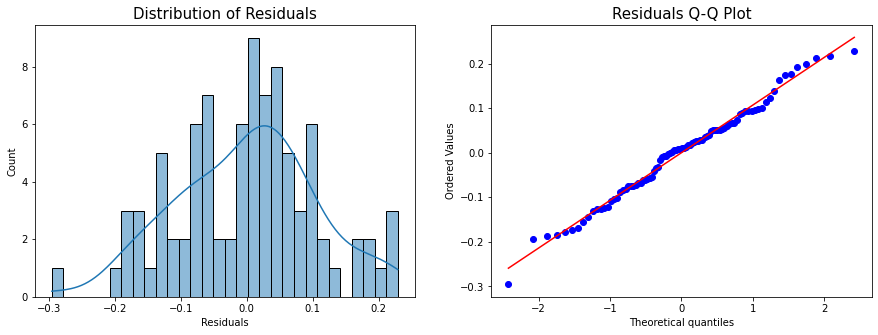

In [294]:
normal_errors_assumption(poly_reg, X_poly_test, y_poly_test)

In [295]:
warnings.simplefilter(action='ignore')
multicollinearity_assumption(X_poly)

There is multicollinearity.


,vif
Age,5810.18
Present_Price,1604.87
Kms_Driven,2682.04
Owner,inf
Fuel_Type_Diesel,inf
Seller_Type_Individual,inf
Transmission_Manual,inf
Age^2,2193.42
Age Present_Price,1980.86
Age Kms_Driven,1990.26


In [296]:
autocorrelation_assumption(poly_reg, X_poly_test, y_poly_test)

Durbin-Watson: 2.044
No autocorrelation. Assumption satisfied. 



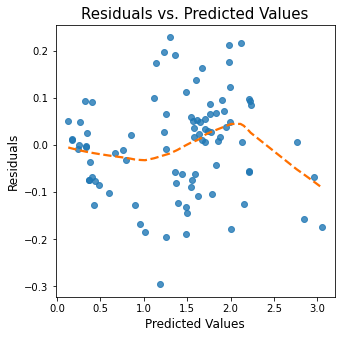

In [297]:
homoscedasticity_assumption(poly_reg, X_poly_test, y_poly_test)

## Ridge Regression

### Split Dataset

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)

### Scale Data

In [299]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train the Model

In [300]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge_cv = RidgeCV(alphas=alphas, cv=3)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        cv=3)

In [301]:
ridge_cv.alpha_

0.06164233697210317

### Model Evaluation

In [302]:
model_evaluation(ridge_cv, X_test, y_test, 'Ridge Reg.')

,Ridge Reg.
MSE,0.010317
RMSE,0.101571
R2-score,0.979451


### Assumptions

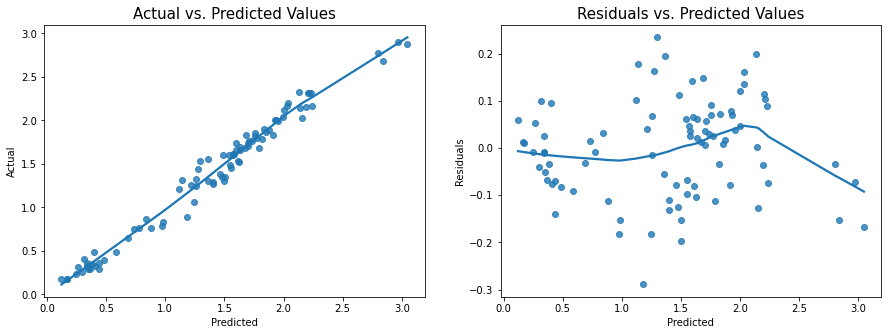

In [303]:
linear_assumption(ridge_cv, X_test, y_test)

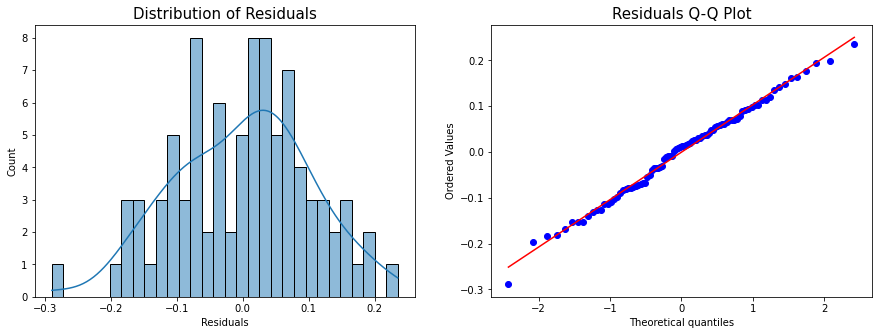

In [304]:
normal_errors_assumption(ridge_cv, X_test, y_test)

In [305]:
multicollinearity_assumption(X_poly)

There is multicollinearity.


,vif
Age,5810.18
Present_Price,1604.87
Kms_Driven,2682.04
Owner,inf
Fuel_Type_Diesel,inf
Seller_Type_Individual,inf
Transmission_Manual,inf
Age^2,2193.42
Age Present_Price,1980.86
Age Kms_Driven,1990.26


In [306]:
autocorrelation_assumption(ridge_cv, X_test, y_test)

Durbin-Watson: 2.098
No autocorrelation. Assumption satisfied. 



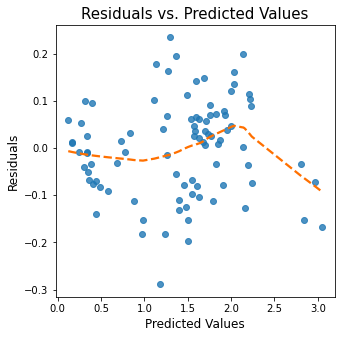

In [307]:
homoscedasticity_assumption(ridge_cv, X_test, y_test)

## Lasso Regression

In [308]:
lasso_cv = LassoCV(cv=3)
lasso_cv.fit(X_train, y_train)

LassoCV(cv=3)

In [309]:
lasso_cv.alpha_

0.0006799897999574147

In [310]:
lasso_coef = pd.DataFrame(lasso_cv.coef_, index=X_poly.columns, columns=['Lasso_coef'])
lasso_coef = lasso_coef[lasso_coef["Lasso_coef"] != 0]
lasso_coef

,Lasso_coef
Age,0.225823
Present_Price,0.948357
Kms_Driven,0.003246
Age^2,-0.237489
Age Present_Price,-0.416555
Age Kms_Driven,-0.063706
Present_Price Owner,-0.034658
Present_Price Fuel_Type_Diesel,0.067052
Present_Price Seller_Type_Individual,0.064923
Kms_Driven Fuel_Type_Diesel,0.008636


### Model Evaluation

In [311]:
model_evaluation(lasso_cv, X_test, y_test, 'Lasso Reg.')

,Lasso Reg.
MSE,0.012651
RMSE,0.112479
R2-score,0.974800


### Assumptions

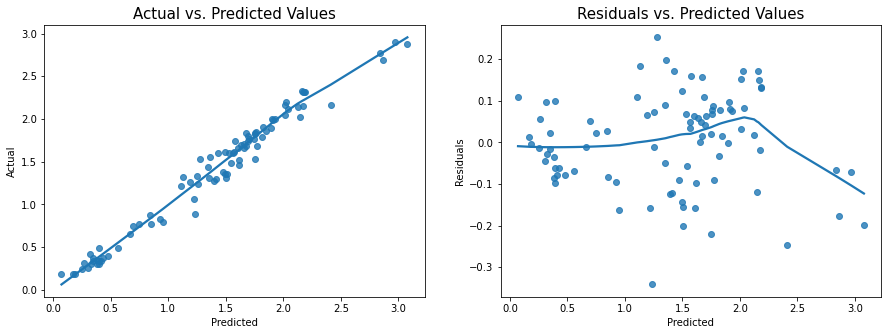

In [312]:
linear_assumption(lasso_cv, X_test, y_test)

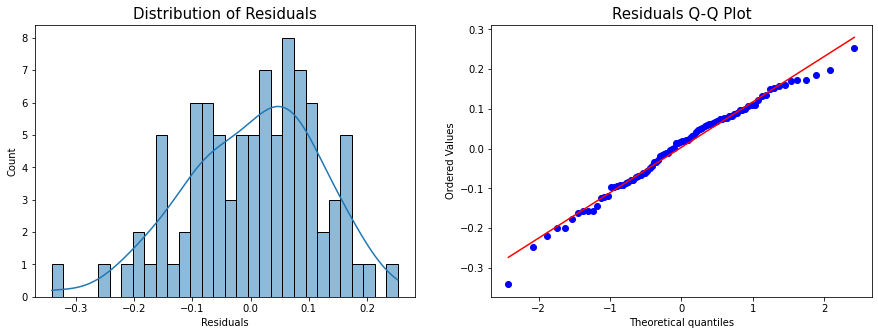

In [313]:
normal_errors_assumption(lasso_cv, X_test, y_test)

In [314]:
multicollinearity_assumption(X_poly[lasso_coef.index])

There is multicollinearity.


,vif
Age,1470.88
Present_Price,242.27
Kms_Driven,888.68
Age^2,1035.51
Age Present_Price,234.55
Age Kms_Driven,811.56
Present_Price Owner,3.50
Present_Price Fuel_Type_Diesel,26.93
Present_Price Seller_Type_Individual,12.36
Kms_Driven Fuel_Type_Diesel,36.17


In [315]:
autocorrelation_assumption(lasso_cv, X_test, y_test)

Durbin-Watson: 2.068
No autocorrelation. Assumption satisfied. 



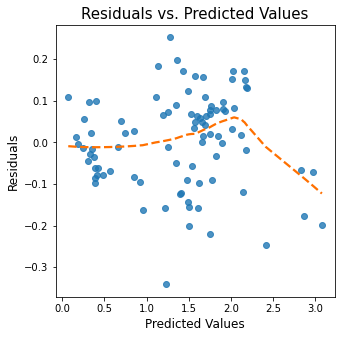

In [316]:
homoscedasticity_assumption(lasso_cv, X_test, y_test)